# Text Analytics - Assignment 2
# (Text Classification With Multi-Layer Perceptrons)

---
> Kostis Konstantinos (p3352311) <br>
> MSc Data-Science (Part-Time) <br>
> Athens University Of Economics and Business

## Exercice 10 (POS Tagger)

In this exercise we implement a Part-Of-Speech tagger. The POS tagger is implemented as a classifier of words to part-of-speech tags.\
The main objective is to create a tagger using a Multi-Layer Perceptron with the maximum possible correctness (classification power).\
To do that we will firstly create a baseline classifier which for a word that was present in the training set always responds with its most frequent tag \
and if it was not encountered in the training set always responds with the most frequent tag (over all words) of the training set.

In [1]:
# Install libraries (via pip) for Google Colab

#!pip install -U conllu gensim pandas requests tensorflow keras-tuner scikit-learn matplotlib

In [2]:
# Load libraries
import os

# INFO, WARNING and ERROR messages are not printed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

from io import open
from collections import Counter

from conllu import parse_incr
import requests

import gensim.downloader as api

import numpy as np
import pandas as pd

import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import (f1_score, recall_score, precision_score, classification_report, 
auc, precision_recall_curve, roc_auc_score)
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

### Setting a random seed (for reproducibility)

In [3]:
seed = 2024
np.random.seed(seed)
tf.random.set_seed(seed)

### Dataset (Description & Helper classes)

The dataset used, refers to the english language of the Universal Dependencies tree banks and more specifically GUM from Georgetown University.\
It contains 10761 sentences from different genres: academic, blog, fiction, government, news, nonfiction, social, spoken, web, wiki. \
The dataset is downloaded from Github and parsed using the `conllu` package, via a custom class named `DatasetHandler`.

Treebank index page can be found here [https://universaldependencies.org/treebanks/en_gum/index.html](https://universaldependencies.org/treebanks/en_gum/index.html) \
The actual data (train, dev, test) files can be found at [https://github.com/UniversalDependencies/UD_English-GUM/tree/master](https://github.com/UniversalDependencies/UD_English-GUM/tree/master)

In [4]:
# Download and parse train, dev and test splits (download from github)

class DatasetHandler:
    """ DatasetHandler
    
    Downloads and parses the universal-dependencies/en-gmu data files.
    """
    def __init__(self, url, mode):
        self.url = url
        self.mode = mode

        self.sentences = []
        
        self.data_directory = 'data'
        self.data_file = os.path.join(self.data_directory, "{}.conllu".format(self.mode))

    def fetch(self):
        if not os.path.exists(self.data_directory):
            os.makedirs(self.data_directory)

        if not os.path.exists(self.data_file):
            self.download()

        handle = open(self.data_file, "r", encoding="utf-8")
        for tokenlist in parse_incr(handle):
            sentence = []

            for token in tokenlist:
                if not token['form']:
                    continue
                sentence.append((token['form'].lower(), token['upos']))

            self.sentences.append(sentence)

    def basic_stats(self):
        n_sentences = len(self.sentences)

        words = []
        average_sentence_length = 0
        
        for sentence in self.sentences:
            average_sentence_length += len(sentence)

            for item in sentence:
                words.append(item[0])

        average_sentence_length /= n_sentences 

        n_words = len(words)
        n_unique_words = len(set(words))

        stats = [[self.mode, n_sentences, round(average_sentence_length,1), n_words, n_unique_words]]
        df = pd.DataFrame(stats, columns=['Dataset', 'Sentences', 'Average Sentence Length', 'Words', 'Unique Words'])
        
        return df

    def download(self):
        response = requests.get(self.url)
        with open(self.data_file, mode="wb") as file:
            file.write(response.content)

In [5]:
class SentenceUtils:
    """Sentence utility methods."""

    @staticmethod
    def tokens_of(tagged_sentence):
        return [token for (token, tag) in tagged_sentence]

    @staticmethod
    def pos_of(tagged_sentence):
        return [tag for (token, tag) in tagged_sentence]

    @staticmethod
    def texts(sentences):
        return [ __class__.tokens_of(sentence) for sentence in sentences]

    @staticmethod
    def tags(sentences):
        return [ __class__.pos_of(sentence) for sentence in sentences]

    @staticmethod
    def flatten_texts(sentences):
        return [token
                for tokenList in __class__.texts(sentences)
                for token in tokenList]

    @staticmethod
    def flatten_tags(sentences):
        return [tag 
                for tagList in __class__.tags(sentences)
                for tag in tagList]

In [6]:
# Fetch/Parse the data

train_url = 'https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-train.conllu'
dev_url = 'https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-dev.conllu'
test_url = 'https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-test.conllu'

train_ds_handler = DatasetHandler(train_url, 'train')
train_ds_handler.fetch()

dev_ds_handler = DatasetHandler(dev_url, 'dev')
dev_ds_handler.fetch()

test_ds_handler = DatasetHandler(test_url, 'test')
test_ds_handler.fetch()

### Basic statistics
Below you can find some basic statistics regarding the train, dev and test sets.
Reported statistics are:

- Dataset split
- Number of sentences
- Average sentence length
- Number of words
- Number of unique words

In [7]:
train_stats = train_ds_handler.basic_stats()
dev_stats = dev_ds_handler.basic_stats()
test_stats = test_ds_handler.basic_stats()

stats = pd.concat([train_stats, dev_stats, test_stats], ignore_index=True)

stats

,Dataset,Sentences,Average Sentence Length,Words,Unique Words
0,train,9521,17.5,166918,15555
1,dev,1341,18.2,24375,4302
2,test,1285,18.9,24330,4819


### Helper method for generating a classification report

This section refers to an implementation of a method that produces a classification report
for a given dataset. The dimensions of this report include:

- Precision (For each POS tag)
- Recall (For each POS tag)
- F1 (For each POS tag)
- Precision-Recall AUC (For each POS Tag)
- Macro avegerages for the above metrics

The report is given as pandas dataframes.

In [8]:
# Classification report implementation
class EvaluationMetrics:

    @staticmethod
    def classification_report(y_true, y_probabilities, y_predicted, class_ids, class_labels):
        """ Creates a classification report for a multi-class classsification problem.

        Note: Scikit-Learn's precision_recall_curve has its output reversed. See:
        https://github.com/scikit-learn/scikit-learn/issues/2097
        
        Args:
            y_true: A one dimensional array(n_samples), containing the actual class id per sample.
            y_probabilities: A 2D array (n_samples, n_classes) containing the predicted probabilities
                per sample.
            y_predicted: A one dimensional array(n_samples) containing the predicted class id per sample.
            class_ids: A one dimensional array (n_classes) containing the ids of classes.
            class_labels: A one dimensional array (n_classes) containing the names of the classes.
        """

        # Compute precision (per class)
        precision = precision_score(y_true, y_predicted, average=None)

        # Compute recall (per class)
        recall = recall_score(y_true, y_predicted, average=None)

        # Compute F1 (per class)
        f1 = f1_score(y_true, y_predicted, average=None)

        # Compute Precision-Recall AUC score (per class)
        auc_scores = []
        for class_id in class_ids:
            class_indices = (y_true == class_id)
            if any(class_indices):
                class_precision, class_recall, thresholds = precision_recall_curve(
                    class_indices.astype(int), y_probabilities[:, class_id])
                class_precision_recall_auc = auc(class_recall, class_precision)
                auc_scores.append(class_precision_recall_auc)

        classification_report_df = pd.DataFrame()
        classification_report_df['Class Id'] = class_ids
        classification_report_df['Class Name'] = class_labels
        classification_report_df['Precision'] = precision
        classification_report_df['Recall'] = recall
        classification_report_df['F1'] = f1
        classification_report_df['Precision-Recall AUC'] = auc_scores
    
        macro_average_df = pd.DataFrame()
        macro_average_df['Macro Average Precision'] = [np.mean(precision)]
        macro_average_df['Macro Average Recall'] = [np.mean(recall)]
        macro_average_df['Macro Average F1'] = [np.mean(f1)]
        macro_average_df['Macro Average Precision Recall AUC'] = [np.mean(auc_scores)]
    
        return (classification_report_df, macro_average_df)

## POS Tagger: Baseline Classifier (most frequent tag)

This section implements a baseline classifier, that utilizes the most frequent tag (POS tag) given a word.\
Essentially, fitting the baseline simply means counting the occurencies of (word, tag) pairs.\
Consequently, during inference when a word is given the most frequent tag of the word is selected.\
In case the given word was not seen in the training set, then the most frequent tag over all tags is selected.\
This is a custom implementation with a Scikit-Learn compatible interface.

In [9]:
# Baseline (Most frequent tag) implementation
class MostFrequentTagClassifier:
    def __init__(self):
        self.word2tag = {}
        self.most_frequent_tag = None
        self.tag2id = {}

    def fit(self, X):
        pair_frequencies = {}
        tag_frequencies = Counter()

        # Collect counts for tags and pairs of word/tag
        for sentence in X:
            for (word, tag) in sentence:
                if word not in pair_frequencies:
                    pair_frequencies[word] = Counter()
                pair_frequencies[word][tag] += 1
                tag_frequencies[tag] += 1

        # Persist the overall most frequent tag and the most frequent tag per word
        self.most_frequent_tag = tag_frequencies.most_common()[0][0]
        for word in pair_frequencies.keys():
            self.word2tag[word] = pair_frequencies[word].most_common()[0][0]

        tags = list(tag_frequencies.keys())
        self.tag2id = {tag: idx for (idx, tag) in enumerate(tags)}

        return self

    def predict(self, word):
        prediction = None

        if word not in self.word2tag:
            prediction = self.most_frequent_tag
        else:
            prediction = self.word2tag[word]

        return self.tag2id[prediction]

    def predict_proba(self, word):
        prediction = self.predict(word)

        return to_categorical([prediction], num_classes=len(self.tag2id))

    def evaluate(self, dataset):
        tokens = SentenceUtils.flatten_texts(dataset)
        tags = SentenceUtils.flatten_tags(dataset)

        y_true = np.array([self.tag2id[tag] for tag in tags])
        y_predicted = np.array([self.predict(token) for token in tokens])

        y_probabilities = []
        for token in tokens:
            y_probabilities.append(self.predict_proba(token))
        y_probabilities = np.array(y_probabilities).reshape((len(tokens), len(self.tag2id)))

        class_ids = list(self.tag2id.values())
        class_labels = list(self.tag2id.keys())

        return EvaluationMetrics.classification_report(
            y_true, y_probabilities, y_predicted, class_ids, class_labels)

In [10]:
# Instantiate and fit the MostFrequentTagClassifier
most_frequent_tag_classifier = MostFrequentTagClassifier().fit(train_ds_handler.sentences)

In [11]:
# Baseline evaluation (train set)
train_set = train_ds_handler.sentences
train_classification_report_df, train_macro_average_df = most_frequent_tag_classifier.evaluate(train_set)

In [12]:
train_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,0,ADJ,0.905493,0.932019,0.918565,0.920946
1,1,NOUN,0.923814,0.939181,0.931434,0.936470
2,2,CCONJ,0.994413,0.990724,0.992565,0.992718
3,3,PUNCT,0.995007,0.998593,0.996797,0.996896
4,4,ADP,0.905744,0.888595,0.897087,0.902333
5,5,PROPN,0.924751,0.828910,0.874212,0.881716
6,6,VERB,0.923371,0.898068,0.910544,0.915968
7,7,ADV,0.915924,0.824751,0.867950,0.874456
8,8,AUX,0.870135,0.947965,0.907384,0.910425
9,9,DET,0.946340,0.977793,0.961810,0.962953


## Building a Multi-Layer Perceptron

### Loading pretrained word embeddingns

In [13]:
glove_100 = api.load("glove-wiki-gigaword-100")
# word2vec = api.load('word2vec-google-news-300')

### Encoding the labels

In [14]:
tags = SentenceUtils.tags(train_ds_handler.sentences)
pos_tags = set()

for sentence_tags in tags:
    for tag in sentence_tags:
        pos_tags.add(tag)

tag2id = {tag: idx for (idx, tag) in enumerate(pos_tags)}
pos_tags_encoder = LabelBinarizer()
tags_encoded = pos_tags_encoder.fit_transform(list(tag2id.values()))

### Feature engineering (using the pretrained embeddings)

In this section a class named `Featurizer` is created. This class is responsible to encode, the given center word and its context/window words, as a single vector.\
The `window_size` and the `embeddings_model` are parameterizable in order to facilitate experimentation.

In [15]:
class Featurizer:
    def __init__(self, embeddings_model, tag2id, tags_encoded):
        self.embeddings_model = embeddings_model
        self.dimensionality = embeddings_model.vectors.shape[-1]
        # padding for start/end of sentence
        self.pad_vector = np.zeros(self.dimensionality)
        # oov vector signifies a given word that was not present in the embeddings model
        min_value = np.min(embeddings_model.vectors)
        self.oov_vector = np.array([min_value - 10.0] * self.dimensionality)
        self.tag2id = tag2id
        self.tags_encoded = tags_encoded

    def process(self, sentence, position, window_size=1):
        """ Convert a word and its context into a vector.

        The method used, is concatenation (not the summation)
        
        Args:
            sentence: A list of string words
            position: Integer position of the center word
            window_size: The size of window/words before and after the center word
        """
        featurized = np.array([])
        
        for idx in range(position - window_size, position + window_size + 1):
            if idx < 0:
                featurized = np.append(featurized, self.pad_vector)
                continue
            if idx > len(sentence) - 1:
                featurized = np.append(featurized, self.pad_vector)
                continue

            try:
                featurized = np.append(featurized, self.embeddings_model[sentence[idx]])
            except KeyError:
                featurized = np.append(featurized, self.oov_vector)

        return featurized

    def process_dataset(self, dataset, window_size=1):
        """
            Process a dataset (train/val/test) by featurizing
            the words of its sentences.

            Args:
                dataset: A list of sentences. Each sentence is represented
                    as a list of tuples, where a tuple contains a word as
                    the first element and the POS tag as a second element.
                window_size: The size of window/words before and after the center word
        """
        X, y = [], []

        for doc_index, tagged_sentence in enumerate(dataset):
            sentence_words = SentenceUtils.tokens_of(tagged_sentence)
            sentence_tags = SentenceUtils.pos_of(tagged_sentence)
            
            for word_index in range(len(tagged_sentence)):
                featurized = self.process(sentence_words, word_index, window_size)
                tag_id = self.tag2id[sentence_tags[word_index]]
                tag_encoded = self.tags_encoded[tag_id]

                X.append(featurized)
                y.append(tag_encoded)

        return np.array(X), np.array(y)

In [16]:
# An example to check the correctness of the output shape of featurizer.process
featurizer = Featurizer(glove_100, tag2id, tags_encoded)
example = SentenceUtils.tokens_of(train_ds_handler.sentences[100])

featurized_example_1 = featurizer.process(example, 5, window_size=1)
assert featurized_example_1.shape[0] == featurizer.dimensionality * 3

featurized_example_2 = featurizer.process(example, 5, window_size=2)
assert featurized_example_2.shape[0] == featurizer.dimensionality * 5

### MLP tuning

In this section a class named `MLPTaggerTuner` is responsible for tuning hyper-parameters, given a window_size.\
The values of window_size tested are: 0, 1, 3, 5. \
The hyperparameters tuned include:

- number of layers (with possible values: 1, 2, 3)
- number of hidden units for a layer (min: 128, max: 512, step=64)
- dropout probability (with possible values: 0.1, 0.2, 0.3, 0.4, 0.5)
- learning rate (with possible values: 0.01, 0.001, 0.0001)

Tuning is achieved using `keras-tuner`, with 10 maximum trials, 30 epochs and batch size of 128.
The objective of the tuner is to maximize the validation categorical accuracy).

In [17]:
class MLPTaggerTuner:
    def __init__(self, train_sentences, dev_sentences, featurizer, window_size, train_size=0.5, seed=seed):
        self.window_size = window_size
        self.seed = seed

        train_X, train_y = featurizer.process_dataset(train_sentences, window_size)
        sample_size = int(len(train_X) * train_size)
        
        self.train_X = train_X[0:sample_size+1]
        self.train_y = train_y[0:sample_size+1]

        self.dev_X, self.dev_y = featurizer.process_dataset(dev_sentences, window_size)

    def tune(self):
        tuner = kt.RandomSearch(self.build_model, 
                                objective=kt.Objective("val_categorical_accuracy", direction="max"),
                                max_trials = 10,
                                seed=self.seed,
                                directory='KT_dir',
                                project_name="KT_pos_tuning_window_{}".format(self.window_size))

        early_stopping = EarlyStopping(monitor='val_loss', patience=5)

        tuner.search(self.train_X, self.train_y,
                     validation_data=(self.dev_X, self.dev_y),
                     epochs=30, batch_size = 128,
                     callbacks=[early_stopping])

        return tuner

    def build_model(self, hp):
        model = Sequential()

        layer_index = 0

        for i in range(hp.Int(name='num_layers',min_value=1,max_value=3)):
            if layer_index == 0:
                model.add(Dense(hp.Int(name='hidden_units_'+str(i),min_value=128,max_value=512,step=64),
                                activation=hp.Choice(name='activation_layer'+str(i),values=['relu','tanh']),
                                input_dim=self.train_X.shape[1]
                               ))
                model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5])))
            else:
                model.add(Dense(hp.Int(name='hidden_units_'+str(i),min_value=128,max_value=512,step=64),
                                activation=hp.Choice(name='activation_layer'+str(i),values=['relu','tanh'])))
                model.add(Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2,0.3,0.4,0.5])))
    
            layer_index += 1

        # Add last layer that produces the logits
        model.add(Dense(self.train_y.shape[1],  activation='softmax'))
    
        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=hp_learning_rate),
                      metrics=[CategoricalAccuracy()])

        return model

In [18]:
# # Perform tuning for window_size = 0
# # Run this on Colab using GPU mode
# mlp_tuner_window_0 = MLPTaggerTuner(train_ds_handler.sentences, dev_ds_handler.sentences, featurizer, 0, train_size=0.7)
# tuner_0 = mlp_tuner_window_0.tune()

In [19]:
# Perform tuning for window_size = 1
# Run this on Colab using GPU mode
mlp_tuner_window_1 = MLPTaggerTuner(train_ds_handler.sentences, dev_ds_handler.sentences, featurizer, 1, train_size=0.7)
tuner_1 = mlp_tuner_window_1.tune()

Trial 10 Complete [00h 02m 11s]
val_categorical_accuracy: 0.9156102538108826

Best val_categorical_accuracy So Far: 0.9376410245895386
Total elapsed time: 00h 22m 24s


In [20]:
# # Perform tuning for window_size = 3
# # Run this on Colab using GPU mode
# mlp_tuner_window_3 = MLPTaggerTuner(train_ds_handler.sentences, dev_ds_handler.sentences, featurizer, 3, train_size=0.7)
# tuner_3 = mlp_tuner_window_3.tune()

In [21]:
# # Perform tuning for window_size = 5
# # Run this on Colab using GPU mode
# mlp_tuner_window_5 = MLPTaggerTuner(train_ds_handler.sentences, dev_ds_handler.sentences, featurizer, 5, train_size=0.7)
# tuner_5 = mlp_tuner_window_5.tune()

In [22]:
# Get the hyperparameters of the best tuner
best_hyperparams = tuner_1.get_best_hyperparameters()[0].values

best_hyperparams

{'num_layers': 3,
 'hidden_units_0': 192,
 'activation_layer0': 'relu',
 'dropout_layer_0': 0.2,
 'learning_rate': 0.0001,
 'hidden_units_1': 448,
 'activation_layer1': 'relu',
 'dropout_layer_1': 0.1,
 'hidden_units_2': 256,
 'activation_layer2': 'relu',
 'dropout_layer_2': 0.1}

### Evaluation Metrics Helper Class

In this section a class named `EvaluationMetrics` is created that encapsulates a classification report given a dataset
for a multi-class classification problem. It is used to report metrics on train, dev and test subsets.

It reports (in the form of pandas dataframes) on:

  - Precision
  - Recall
  - F1
  - Precision-Recall AUC score
  - Their Macro Averages


In [23]:
class EvaluationMetrics:

    @staticmethod
    def classification_report(y_true, y_probabilities, y_predicted, class_ids, class_labels):
        """ Creates a classification report for a multi-class classsification problem.

        Note: Scikit-Learn's precision_recall_curve has its output reversed. See:
        https://github.com/scikit-learn/scikit-learn/issues/2097
        
        Args:
            y_true: A one dimensional array(n_samples), containing the actual class id per sample.
            y_probabilities: A 2D array (n_samples, n_classes) containing the predicted probabilities
                per sample.
            y_predicted: A one dimensional array(n_samples) containing the predicted class id per sample.
            class_ids: A one dimensional array (n_classes) containing the ids of classes.
            class_labels: A one dimensional array (n_classes) containing the names of the classes.
        """

        # Compute precision (per class)
        precision = precision_score(y_true, y_predicted, average=None)

        # Compute recall (per class)
        recall = recall_score(y_true, y_predicted, average=None)

        # Compute F1 (per class)
        f1 = f1_score(y_true, y_predicted, average=None)

        # Compute Precision-Recall AUC score (per class)
        auc_scores = []
        for class_id in class_ids:
            class_indices = (y_true == class_id)
            if any(class_indices):
                class_precision, class_recall, thresholds = precision_recall_curve(
                    class_indices.astype(int), y_probabilities[:, class_id])
                class_precision_recall_auc = auc(class_recall, class_precision)
                auc_scores.append(class_precision_recall_auc)

        classification_report_df = pd.DataFrame()
        classification_report_df['Class Id'] = class_ids
        classification_report_df['Class Name'] = class_labels
        classification_report_df['Precision'] = precision
        classification_report_df['Recall'] = recall
        classification_report_df['F1'] = f1
        classification_report_df['Precision-Recall AUC'] = auc_scores
    
        macro_average_df = pd.DataFrame()
        macro_average_df['Macro Average Precision'] = [np.mean(precision)]
        macro_average_df['Macro Average Recall'] = [np.mean(recall)]
        macro_average_df['Macro Average F1'] = [np.mean(f1)]
        macro_average_df['Macro Average Precision Recall AUC'] = [np.mean(auc_scores)]
    
        return (classification_report_df, macro_average_df)

### MLP modeling

In this section the class `MLPTagger` is introduced. This class contains methods for:
- fitting a model (constructing first the next architecture from a dictionary)
- predicting pos tags, given a set of sentences
- plotting curves (train/dev loss and train/dev accuracy vs epochs)
- generating a classification report (for the predictions)

During training we monitor categorical accuracy, loss and f1.\
A `Metrics` class (taken from the course labs) is responsible for recording
f1, precision and recall in the dev (validation) set.

In [24]:
# Metrics class (taken from course labs)
# is added as a callback during training
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        # If val_targ is 1-hot
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
          val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

In [25]:
class MLPTagger:
    def __init__(self, featurizer, window_size):
        self.model = None
        self.history = None
        self.featurizer = featurizer
        self.window_size = window_size

    def fit(self, train_set, dev_set, hyperparams):
        train_X, train_y = featurizer.process_dataset(train_set, self.window_size)
        dev_X, dev_y = featurizer.process_dataset(dev_set, self.window_size)

        self.build_model(hyperparams, train_X.shape[-1], train_y.shape[-1])

        if not os.path.exists('./checkpoints'):
            os.makedirs('./checkpoints')

        checkpoint = ModelCheckpoint('checkpoints/mlp_pos_tagger.weights.h5',
                                     monitor='val_f1',
                                     mode='max', verbose=2,
                                     save_best_only=True,
                                     save_weights_only=True)

        early_stopping = EarlyStopping(patience=10, verbose=2,
                                       restore_best_weights=True,
                                       monitor='val_f1', mode='max')

        self.history = self.model.fit(train_X, train_y,
                            validation_data=(dev_X, dev_y),
                            batch_size=128, epochs=100, shuffle=True,
                            callbacks=[Metrics(valid_data=(dev_X, dev_y)),
                                       checkpoint, early_stopping])

    def classification_report(self, dataset):
        """ Create a classification report for a given dataset."""
        data_X, data_y = self.featurizer.process_dataset(dataset, self.window_size)
        y_true = np.argmax(data_y, -1)
        y_probabilities = self.model.predict(data_X)
        y_predicted = np.argmax(y_probabilities.copy(), -1)
        class_ids = list(self.featurizer.tag2id.values())
        class_labels = list(self.featurizer.tag2id.keys())

        return EvaluationMetrics.classification_report(y_true, y_probabilities, y_predicted, 
                                                       class_ids, class_labels)

    def plot_curves(self):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # summarize history for accuracy
        axs[0].plot(self.history.history['categorical_accuracy'])
        axs[0].plot(self.history.history['val_categorical_accuracy'])
        axs[0].set_title('model accuracy')
        axs[0].set_ylabel('accuracy')
        axs[0].set_xlabel('epoch')
        axs[0].legend(['train', 'dev'], loc='upper left')
        axs[0].set_xticks(range(1,len(self.history.history['categorical_accuracy'])+1,4))
    
        # summarize history for loss
        axs[1].plot(self.history.history['loss'])
        axs[1].plot(self.history.history['val_loss'])
        axs[1].set_title('model loss')
        axs[1].set_ylabel('loss')
        axs[1].set_xlabel('epoch')
        axs[1].legend(['train', 'dev'], loc='upper right')
        axs[1].set_xticks(range(1,len(self.history.history['loss'])+1,4))
    
        # # space between the plots
        plt.tight_layout()
     
        # show plot
        plt.show()

    def build_model(self, hyperparams, input_dim, output_dim):
        self.model = Sequential()

        layer_index = 0

        num_layers = hyperparams.get('num_layers')

        for i in range(num_layers):
            hidden_units = hyperparams.get('hidden_units_'+str(i))
            activation = hyperparams.get('activation_layer'+str(i))
            dropout_proba = hyperparams.get('dropout_layer_'+str(i))

            if layer_index == 0:
                self.model.add(Dense(hidden_units, input_dim=input_dim,
                                name='hidden_units_'+str(i),
                                activation=activation))
                self.model.add(Dropout(dropout_proba, name='dropout_layer_'+str(i)))
            else:
                self.model.add(Dense(hidden_units,
                                name='hidden_units_'+str(i),
                                activation=activation))
                self.model.add(Dropout(dropout_proba, name='dropout_layer_'+str(i)))
    
            layer_index += 1

        # Add last layer that produces the logits
        self.model.add(Dense(output_dim, activation='softmax'))
    
        # Tune the learning rate for the optimizer
        learning_rate = hyperparams.get('learning_rate')
        self.model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=learning_rate),
                      metrics=[CategoricalAccuracy()])

In [26]:
# Instantiate the MLP tagger
mlp_tagger = MLPTagger(featurizer, 1)

In [27]:
# Fit the model
mlp_tagger.fit(train_ds_handler.sentences, dev_ds_handler.sentences, best_hyperparams)

Epoch 1/100
762/762 [==============================] - 1s 2ms/step
 — val_f1: 0.798759 — val_precision: 0.806424 — val_recall: 0.812185

Epoch 1: val_f1 improved from -inf to 0.79876, saving model to checkpoints/mlp_pos_tagger.weights.h5
1305/1305 [==============================] - 14s 11ms/step - loss: 1.2665 - categorical_accuracy: 0.6147 - val_loss: 0.6011 - val_categorical_accuracy: 0.8122 - val_f1: 0.7988 - val_recall: 0.8122 - val_precision: 0.8064
Epoch 2/100
  17/1305 [..............................] - ETA: 8s - loss: 0.7335 - categorical_accuracy: 0.7574

/home/konstantinos/miniconda3/envs/ds-aueb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


762/762 [==============================] - 1s 1ms/step loss
 — val_f1: 0.860360 — val_precision: 0.860404 — val_recall: 0.864328

Epoch 2: val_f1 improved from 0.79876 to 0.86036, saving model to checkpoints/mlp_pos_tagger.weights.h5
1305/1305 [==============================] - 14s 11ms/step - loss: 0.6316 - categorical_accuracy: 0.7980 - val_loss: 0.4343 - val_categorical_accuracy: 0.8643 - val_f1: 0.8604 - val_recall: 0.8643 - val_precision: 0.8604
Epoch 3/100
  16/1305 [..............................] - ETA: 8s - loss: 0.5773 - categorical_accuracy: 0.8179

/home/konstantinos/miniconda3/envs/ds-aueb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


762/762 [==============================] - 1s 2ms/step
 — val_f1: 0.884323 — val_precision: 0.884736 — val_recall: 0.887015

Epoch 3: val_f1 improved from 0.86036 to 0.88432, saving model to checkpoints/mlp_pos_tagger.weights.h5
1305/1305 [==============================] - 16s 12ms/step - loss: 0.5087 - categorical_accuracy: 0.8366 - val_loss: 0.3615 - val_categorical_accuracy: 0.8870 - val_f1: 0.8843 - val_recall: 0.8870 - val_precision: 0.8847
Epoch 4/100
  15/1305 [..............................] - ETA: 9s - loss: 0.4728 - categorical_accuracy: 0.8495

/home/konstantinos/miniconda3/envs/ds-aueb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


762/762 [==============================] - 2s 2ms/step
 — val_f1: 0.891418 — val_precision: 0.892240 — val_recall: 0.893005

Epoch 4: val_f1 improved from 0.88432 to 0.89142, saving model to checkpoints/mlp_pos_tagger.weights.h5
1305/1305 [==============================] - 14s 11ms/step - loss: 0.4391 - categorical_accuracy: 0.8595 - val_loss: 0.3399 - val_categorical_accuracy: 0.8930 - val_f1: 0.8914 - val_recall: 0.8930 - val_precision: 0.8922
Epoch 5/100
  16/1305 [..............................] - ETA: 8s - loss: 0.3978 - categorical_accuracy: 0.8711

/home/konstantinos/miniconda3/envs/ds-aueb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


762/762 [==============================] - 1s 2ms/step
 — val_f1: 0.903411 — val_precision: 0.904085 — val_recall: 0.905682

Epoch 5: val_f1 improved from 0.89142 to 0.90341, saving model to checkpoints/mlp_pos_tagger.weights.h5
1305/1305 [==============================] - 13s 10ms/step - loss: 0.3938 - categorical_accuracy: 0.8739 - val_loss: 0.2972 - val_categorical_accuracy: 0.9057 - val_f1: 0.9034 - val_recall: 0.9057 - val_precision: 0.9041
Epoch 6/100
   9/1305 [..............................] - ETA: 17s - loss: 0.3777 - categorical_accuracy: 0.8819

/home/konstantinos/miniconda3/envs/ds-aueb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


762/762 [==============================] - 1s 2ms/step
 — val_f1: 0.910840 — val_precision: 0.911196 — val_recall: 0.912246

Epoch 6: val_f1 improved from 0.90341 to 0.91084, saving model to checkpoints/mlp_pos_tagger.weights.h5
1305/1305 [==============================] - 15s 11ms/step - loss: 0.3589 - categorical_accuracy: 0.8851 - val_loss: 0.2763 - val_categorical_accuracy: 0.9122 - val_f1: 0.9108 - val_recall: 0.9122 - val_precision: 0.9112
Epoch 7/100
762/762 [==============================] - 1s 1ms/step 
 — val_f1: 0.913765 — val_precision: 0.913998 — val_recall: 0.914708

Epoch 7: val_f1 improved from 0.91084 to 0.91377, saving model to checkpoints/mlp_pos_tagger.weights.h5
1305/1305 [==============================] - 14s 11ms/step - loss: 0.3369 - categorical_accuracy: 0.8918 - val_loss: 0.2629 - val_categorical_accuracy: 0.9147 - val_f1: 0.9138 - val_recall: 0.9147 - val_precision: 0.9140
Epoch 8/100
762/762 [==============================] - 1s 2ms/step
 — val_f1: 0.920410 

In [28]:
mlp_tagger.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_units_0 (Dense)      (None, 192)               57792     
                                                                 
 dropout_layer_0 (Dropout)   (None, 192)               0         
                                                                 
 hidden_units_1 (Dense)      (None, 448)               86464     
                                                                 
 dropout_layer_1 (Dropout)   (None, 448)               0         
                                                                 
 hidden_units_2 (Dense)      (None, 256)               114944    
                                                                 
 dropout_layer_2 (Dropout)   (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 18)               

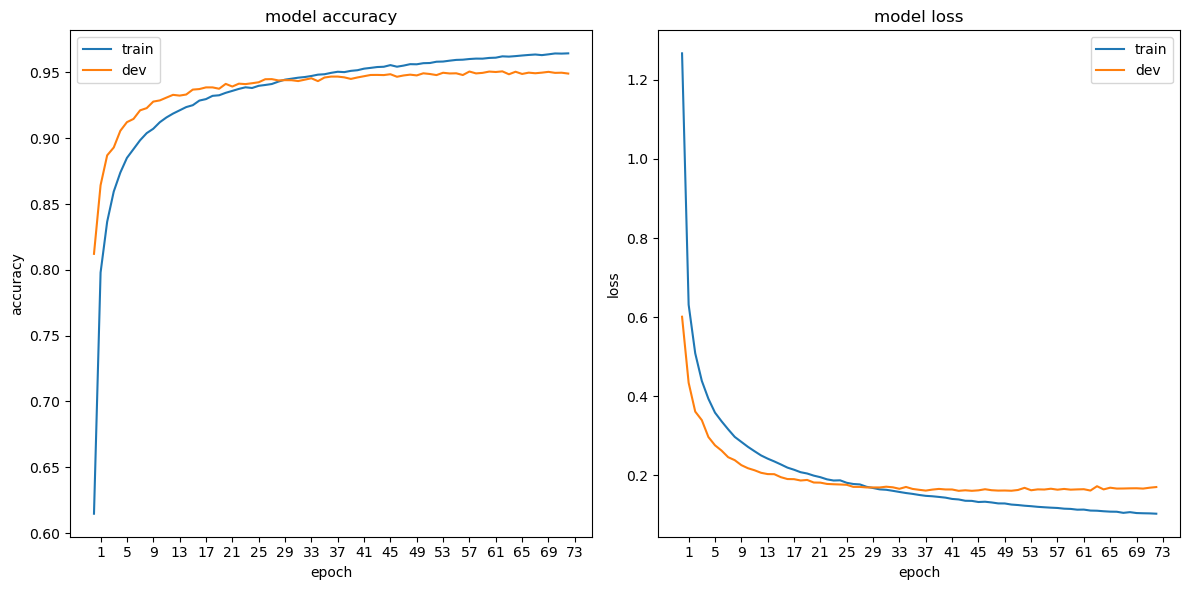

In [29]:
# Plot accuracy and loss curves
mlp_tagger.plot_curves()

### Evaluating the MLP on the training set (Classification Report)

In [30]:
train_set = train_ds_handler.sentences
train_classification_report_df, train_macro_average_df = mlp_tagger.classification_report(train_set)

5217/5217 [==============================] - 7s 1ms/step


In [31]:
train_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,0,AUX,0.993761,0.993085,0.993423,0.999529
1,1,PUNCT,0.999560,0.999297,0.999428,0.999988
2,2,CCONJ,0.996852,0.998701,0.997776,0.999920
3,3,SCONJ,0.944380,0.916918,0.930446,0.981140
4,4,NUM,0.988561,0.982008,0.985273,0.997966
5,5,PROPN,0.949785,0.902759,0.925675,0.982976
6,6,INTJ,0.960517,0.837297,0.894684,0.960093
7,7,VERB,0.988630,0.986502,0.987565,0.998712
8,8,_,0.903226,0.976512,0.938440,0.984402
9,9,PART,0.995672,0.993901,0.994786,0.999545


In [32]:
train_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.97565,0.943317,0.95567,0.983422


### Evaluating the MLP on the dev set (Classification Report)

In [33]:
dev_set = dev_ds_handler.sentences
dev_classification_report_df, dev_macro_average_df = mlp_tagger.classification_report(dev_set)

762/762 [==============================] - 1s 2ms/step


In [34]:
dev_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,0,AUX,0.985174,0.982262,0.983716,0.997072
1,1,PUNCT,0.997802,0.999371,0.998586,0.999961
2,2,CCONJ,0.986811,0.993961,0.990373,0.999369
3,3,SCONJ,0.833773,0.782178,0.807152,0.884030
4,4,NUM,0.963446,0.960938,0.962190,0.990591
5,5,PROPN,0.858661,0.785992,0.820721,0.896626
6,6,INTJ,0.909502,0.785156,0.842767,0.930959
7,7,VERB,0.947813,0.922675,0.935075,0.981827
8,8,_,0.936842,0.978022,0.956989,0.977987
9,9,PART,0.977511,0.986384,0.981928,0.998205


In [35]:
dev_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.920253,0.890698,0.903479,0.932526


### Evaluating the MLP on the test set (Classification Report)

In [36]:
test_set = test_ds_handler.sentences
test_classification_report_df, test_macro_average_df = mlp_tagger.classification_report(test_set)

761/761 [==============================] - 1s 1ms/step


In [37]:
test_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,0,AUX,0.981340,0.973087,0.977196,0.994956
1,1,PUNCT,0.998678,0.998348,0.998513,0.999924
2,2,CCONJ,0.991677,0.994041,0.992857,0.999389
3,3,SCONJ,0.832317,0.802941,0.817365,0.873525
4,4,NUM,0.961798,0.972727,0.967232,0.991866
5,5,PROPN,0.850902,0.753686,0.799349,0.884637
6,6,INTJ,0.885135,0.803681,0.842444,0.885570
7,7,VERB,0.948633,0.923387,0.935840,0.979367
8,8,_,0.843501,0.978462,0.905983,0.952154
9,9,PART,0.956604,0.976879,0.966635,0.992150


In [38]:
test_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.922015,0.889315,0.899095,0.929251
